# 📦 RAG Chunking Methods — Multi-Document Comparison

Tests 4 chunking strategies across **multiple Wikipedia documents**:

| # | Method | Strategy |
|---|--------|----------|
| 1 | **Overlap Chunking** | Fixed-size with sliding window |
| 2 | **Semantic Chunking** | Split on embedding similarity drops |
| 3 | **Hierarchical Chunking** | Parent → Child structure |
| 4 | **Context-Aware / LLM Chunking** | LLM-decided boundaries |

> All chunks carry `doc_id` and `doc_title` so you always know which document a chunk came from.

## 1. Install Dependencies

In [1]:
!pip install -q sentence-transformers transformers tiktoken nltk requests scikit-learn

In [2]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print('NLTK ready')

NLTK ready


## 2. Download Multiple Documents

Add or remove titles from `WIKI_TITLES` to control your corpus.  
Each chunk will carry `doc_id` and `doc_title` metadata for traceability.

In [3]:
import requests
import re
import time

# ── Add or remove Wikipedia articles here ────────────────────────────────
WIKI_TITLES = [
    "Artificial intelligence",
    "Machine learning",
    "Natural language processing",
    "Computer vision",
    "Deep learning",
    "Reinforcement learning",
    "Transformer (deep learning architecture)",
    "Large language model",
]

def fetch_wikipedia_article(title: str) -> str:
    url = "https://en.wikipedia.org/w/api.php"
    headers = {"User-Agent": "RAG-Chunking-Notebook/1.0 (educational; contact@example.com)"}
    params = {
        "action": "query", "format": "json", "titles": title,
        "prop": "extracts", "explaintext": True, "exsectionformat": "plain"
    }
    for attempt in range(3):
        try:
            resp = requests.get(url, params=params, headers=headers, timeout=15)
            if resp.status_code != 200:
                print(f"  HTTP {resp.status_code}, retrying...")
                time.sleep(2); continue
            pages = resp.json()["query"]["pages"]
            text  = next(iter(pages.values())).get("extract", "")
            return re.sub(r'\n{3,}', '\n\n', text).strip()
        except Exception as e:
            print(f"  Attempt {attempt+1} failed: {e}")
            time.sleep(2)
    return ""

# ── Fetch all docs ────────────────────────────────────────────────────────
documents = []  # [{doc_id, title, text}, ...]

for doc_id, title in enumerate(WIKI_TITLES):
    print(f"Fetching [{doc_id+1}/{len(WIKI_TITLES)}]: {title} ...", end=" ", flush=True)
    text = fetch_wikipedia_article(title)
    if text:
        documents.append({"doc_id": doc_id, "title": title, "text": text})
        print(f"{len(text):,} chars | {len(text.split()):,} words")
    else:
        print("FAILED — skipped")
    time.sleep(0.5)  # be polite to Wikipedia

# Combined raw_text for methods that don't track doc_id
raw_text = "\n\n".join(d['text'] for d in documents)

total_chars = sum(len(d['text']) for d in documents)
print(f"\n✅ Loaded {len(documents)} documents")
print(f"   Total corpus: {total_chars:,} characters | {len(raw_text.split()):,} words")
print("\n  doc_id | title")
for d in documents:
    print(f"  [{d['doc_id']}]    {d['title']}")

Fetching [1/8]: Artificial intelligence ... 89,156 chars | 13,452 words
Fetching [2/8]: Machine learning ... 59,091 chars | 8,524 words
Fetching [3/8]: Natural language processing ... 32,238 chars | 4,498 words
Fetching [4/8]: Computer vision ... 38,768 chars | 5,724 words
Fetching [5/8]: Deep learning ... 56,217 chars | 8,205 words
Fetching [6/8]: Reinforcement learning ... 51,879 chars | 5,906 words
Fetching [7/8]: Transformer (deep learning architecture) ... FAILED — skipped
Fetching [8/8]: Large language model ... 64,537 chars | 9,095 words

✅ Loaded 7 documents
   Total corpus: 391,886 characters | 55,404 words

  doc_id | title
  [0]    Artificial intelligence
  [1]    Machine learning
  [2]    Natural language processing
  [3]    Computer vision
  [4]    Deep learning
  [5]    Reinforcement learning
  [7]    Large language model


## 3. Utility — Chunk Inspector

In [4]:
def inspect_chunks(chunks, method_name: str, show_n: int = 3):
    """Works with both plain strings and metadata dicts."""
    def get_text(c): return c['text'] if isinstance(c, dict) else c
    def get_meta(c):
        if isinstance(c, dict):
            return f" | doc_id={c.get('doc_id','?')} | {c.get('doc_title','?')[:35]}"
        return ""

    lengths = [len(get_text(c)) for c in chunks]
    print(f"\n{'='*65}")
    print(f"  Method        : {method_name}")
    print(f"  Total chunks  : {len(chunks)}")
    print(f"  Avg chars     : {sum(lengths)/len(lengths):.0f}")
    print(f"  Min chars     : {min(lengths)}")
    print(f"  Max chars     : {max(lengths)}")
    print(f"{'='*65}")
    for i, chunk in enumerate(chunks[:show_n]):
        text = get_text(chunk)
        meta = get_meta(chunk)
        print(f"  [Chunk {i+1}] ({len(text)} chars){meta}:")
        print(f"  {text[:200].replace(chr(10),' ')}...")
    print()

---
## 4. Method 1 — Overlap Chunking (Fixed-Size + Sliding Window)

The simplest and most common approach. Split the text into fixed-size character windows with a configurable overlap so context is not lost at boundaries.

In [5]:
def overlap_chunking_multidoc(documents: list, chunk_size: int = 600, overlap: int = 150) -> list:
    """
    Overlap chunking across multiple documents.
    Returns list of dicts: {text, doc_id, doc_title, chunk_index}
    """
    all_chunks = []
    step = chunk_size - overlap
    for doc in documents:
        start, local_idx = 0, 0
        while start < len(doc['text']):
            chunk_text = doc['text'][start : start + chunk_size].strip()
            if chunk_text:
                all_chunks.append({
                    "text"        : chunk_text,
                    "doc_id"      : doc['doc_id'],
                    "doc_title"   : doc['title'],
                    "chunk_index" : local_idx
                })
                local_idx += 1
            start += step
    return all_chunks


CHUNK_SIZE = 600
OVERLAP    = 150

overlap_chunks = overlap_chunking_multidoc(documents, chunk_size=CHUNK_SIZE, overlap=OVERLAP)
inspect_chunks(overlap_chunks, f"Overlap Chunking (size={CHUNK_SIZE}, overlap={OVERLAP})")

print("  Chunks per document:")
for doc in documents:
    n = sum(1 for c in overlap_chunks if c['doc_id'] == doc['doc_id'])
    print(f"    [{doc['doc_id']}] {doc['title']}: {n} chunks")


  Method        : Overlap Chunking (size=600, overlap=150)
  Total chunks  : 875
  Avg chars     : 595
  Min chars     : 56
  Max chars     : 600
  [Chunk 1] (600 chars) | doc_id=0 | Artificial intelligence:
  Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec...
  [Chunk 2] (599 chars) | doc_id=0 | Artificial intelligence:
  efined goals. High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google...
  [Chunk 3] (600 chars) | doc_id=0 | Artificial intelligence:
  d as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI because once something becomes useful enough and common enough it's not labeled AI anymore." Va...

  Chunks per document:
    [0] Artificial intell

---
## 5. Method 2 — Semantic Chunking (Embedding Similarity)

Sentences are embedded and a new chunk starts wherever the cosine similarity between two consecutive sentence embeddings drops below a threshold, indicating a topic shift.

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np
from nltk.tokenize import sent_tokenize

print("Loading embedding model...")
embed_model = SentenceTransformer("all-MiniLM-L6-v2")
print("Embedding model loaded.")

Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded.


In [7]:
def cosine_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))


def semantic_chunking_multidoc(
    documents: list,
    model,
    similarity_threshold: float = 0.75,
    min_chunk_sentences: int = 3,
    max_chunk_sentences: int = 20
) -> list:
    """
    Semantic chunking across multiple documents.
    Each document is chunked independently (no cross-doc merging).
    Returns list of dicts: {text, doc_id, doc_title}
    """
    all_chunks = []

    for doc in documents:
        print(f"  [{doc['doc_id']}] {doc['title']}...")
        sentences = sent_tokenize(doc['text'])
        if not sentences:
            continue

        embeddings = model.encode(sentences, batch_size=64, show_progress_bar=False)
        current_group = [sentences[0]]

        for i in range(1, len(sentences)):
            sim = cosine_sim(embeddings[i-1], embeddings[i])
            n   = len(current_group)
            should_split = (
                (sim < similarity_threshold and n >= min_chunk_sentences)
                or n >= max_chunk_sentences
            )
            if should_split:
                all_chunks.append({
                    "text"      : " ".join(current_group),
                    "doc_id"    : doc['doc_id'],
                    "doc_title" : doc['title']
                })
                current_group = [sentences[i]]
            else:
                current_group.append(sentences[i])

        if current_group:
            all_chunks.append({
                "text"      : " ".join(current_group),
                "doc_id"    : doc['doc_id'],
                "doc_title" : doc['title']
            })

    return all_chunks


SIM_THRESHOLD = 0.75

print("Running semantic chunking across all documents...")
semantic_chunks = semantic_chunking_multidoc(
    documents, model=embed_model,
    similarity_threshold=SIM_THRESHOLD,
    min_chunk_sentences=3, max_chunk_sentences=20
)
inspect_chunks(semantic_chunks, f"Semantic Chunking (threshold={SIM_THRESHOLD})")

print("  Chunks per document:")
for doc in documents:
    n = sum(1 for c in semantic_chunks if c['doc_id'] == doc['doc_id'])
    print(f"    [{doc['doc_id']}] {doc['title']}: {n} chunks")

Running semantic chunking across all documents...
  [0] Artificial intelligence...
  [1] Machine learning...
  [2] Natural language processing...
  [3] Computer vision...
  [4] Deep learning...
  [5] Reinforcement learning...
  [7] Large language model...

  Method        : Semantic Chunking (threshold=0.75)
  Total chunks  : 863
  Avg chars     : 452
  Min chars     : 25
  Max chars     : 3238
  [Chunk 1] (853 chars) | doc_id=0 | Artificial intelligence:
  Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec...
  [Chunk 2] (515 chars) | doc_id=0 | Artificial intelligence:
  However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI because once something becomes useful enough and ...
  [Chunk 3] (530 chars) | doc_id=0 | Artificial intelligence:
  To

---
## 6. Method 3 — Hierarchical Chunking (Parent → Child)

Creates two levels of chunks:
- **Parent chunks**: Large (~1000 chars) — provide full context for generation
- **Child chunks**: Small (~200 chars) — used for precise retrieval

Each child carries a `parent_id` reference so you can always retrieve full context.

In [8]:
from dataclasses import dataclass, field

@dataclass
class ChildChunk:
    text: str
    parent_id: int
    child_id: int
    doc_id: int
    doc_title: str

@dataclass
class ParentChunk:
    text: str
    parent_id: int
    doc_id: int
    doc_title: str
    children: list = field(default_factory=list)


def hierarchical_chunking_multidoc(
    documents: list,
    parent_size: int = 1000,
    child_size: int = 200,
    parent_overlap: int = 100,
    child_overlap: int = 30
) -> tuple:
    """
    Hierarchical chunking across multiple documents.
    Each doc gets its own parent/child chunks with doc metadata.
    """
    all_parents  = []
    all_children = []
    parent_counter = 0
    child_counter  = 0

    for doc in documents:
        text = doc['text']
        start, p_step = 0, parent_size - parent_overlap

        while start < len(text):
            p_text = text[start : start + parent_size].strip()
            if p_text:
                parent = ParentChunk(
                    text=p_text, parent_id=parent_counter,
                    doc_id=doc['doc_id'], doc_title=doc['title']
                )
                # Build sentence-based children (fixes mid-word cuts)
                sentences = sent_tokenize(p_text)
                c_buffer  = []
                c_chars   = 0
                for sent in sentences:
                    c_buffer.append(sent)
                    c_chars += len(sent)
                    if c_chars >= child_size:
                        c_text = " ".join(c_buffer).strip()
                        child  = ChildChunk(
                            text=c_text, parent_id=parent_counter,
                            child_id=child_counter,
                            doc_id=doc['doc_id'], doc_title=doc['title']
                        )
                        parent.children.append(child)
                        all_children.append(child)
                        child_counter += 1
                        c_buffer, c_chars = [], 0
                if c_buffer:
                    c_text = " ".join(c_buffer).strip()
                    child  = ChildChunk(
                        text=c_text, parent_id=parent_counter,
                        child_id=child_counter,
                        doc_id=doc['doc_id'], doc_title=doc['title']
                    )
                    parent.children.append(child)
                    all_children.append(child)
                    child_counter += 1

                all_parents.append(parent)
                parent_counter += 1
            start += p_step

    return all_parents, all_children


PARENT_SIZE = 1000
CHILD_SIZE  = 200

parent_chunks, child_chunks = hierarchical_chunking_multidoc(
    documents, parent_size=PARENT_SIZE, child_size=CHILD_SIZE
)

print(f"{'='*65}")
print(f"  Method             : Hierarchical Chunking (sentence-based children)")
print(f"  Total parent chunks: {len(parent_chunks)}")
print(f"  Total child chunks : {len(child_chunks)}")
print(f"  Avg children/parent: {len(child_chunks)/len(parent_chunks):.1f}")
print(f"{'='*65}")

print("\n  Chunks per document:")
for doc in documents:
    np_ = sum(1 for p in parent_chunks if p.doc_id == doc['doc_id'])
    nc_ = sum(1 for c in child_chunks  if c.doc_id == doc['doc_id'])
    print(f"    [{doc['doc_id']}] {doc['title']}: {np_} parents, {nc_} children")

# Show a sample
sample = parent_chunks[0]
print(f"\n[Parent 0] doc='{sample.doc_title}' ({len(sample.text)} chars):")
print(f"  {sample.text[:250]}...")
print(f"\n  -> {len(sample.children)} children (sentence-based, no mid-word cuts):")
for c in sample.children[:3]:
    print(f"     [Child {c.child_id}]: {c.text[:120]}...")

  Method             : Hierarchical Chunking (sentence-based children)
  Total parent chunks: 439
  Total child chunks : 1653
  Avg children/parent: 3.8

  Chunks per document:
    [0] Artificial intelligence: 100 parents, 381 children
    [1] Machine learning: 66 parents, 251 children
    [2] Natural language processing: 36 parents, 135 children
    [3] Computer vision: 44 parents, 173 children
    [4] Deep learning: 63 parents, 244 children
    [5] Reinforcement learning: 58 parents, 190 children
    [7] Large language model: 72 parents, 279 children

[Parent 0] doc='Artificial intelligence' (1000 chars):
  Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in compute...

  -> 4 children (sentence-based, no mid-word cuts):
     [Child 0]: Artificial intelligence (AI) is the capability of computatio

---
## 7. Method 4 — Context-Aware / LLM Chunking

We pass text segments to an LLM (LLaMA 3 via Ollama) and ask it to identify natural semantic split points — section starts, topic transitions, etc.

- **Option A**: Ollama running locally (LLaMA 3) — best quality
- **Option B**: Heuristic fallback — paragraph + structural signals, no GPU needed

The notebook auto-detects which to use.

In [9]:
# ---- Setup Ollama in Colab ----

import subprocess
import time

# Install zstd, a dependency for Ollama installation
!sudo apt-get update && sudo apt-get install -y zstd

# Step 1: Install Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Step 2: Start the server in background AFTER install
subprocess.Popen(["ollama", "serve"])
time.sleep(3)  # Give the server a moment to start

# Step 3: Pull the model
!ollama pull llama3

print("Ollama setup complete!")

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,361 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,751 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,613 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnake

In [10]:
import json

def is_ollama_available() -> bool:
    try:
        r = requests.get("http://localhost:11434/api/tags", timeout=3)
        return r.status_code == 200
    except Exception:
        return False

OLLAMA_AVAILABLE = is_ollama_available()
OLLAMA_MODEL = "llama3"  # Change if needed: llama3.1, mistral, phi3, etc.

print(f"Ollama available: {OLLAMA_AVAILABLE}")
if not OLLAMA_AVAILABLE:
    print("Ollama not running — will use heuristic fallback.")
    print("To enable LLaMA chunking, uncomment the setup block above.")

Ollama available: True


In [11]:
LLM_CHUNK_PROMPT = """\
You are a text segmentation assistant. I will give you a list of numbered sentences.
Identify natural breakpoints where a new topic or subtopic begins.

Return ONLY a JSON array of sentence indices where a new chunk should start, like:
[0, 5, 11, 18]

Rules:
- Index 0 always starts the first chunk.
- A value N means sentence N starts a new chunk.
- Aim for 4 to 8 chunks total.
- Return ONLY the JSON array. No explanation, no markdown.

Sentences:
{sentences}
"""

def llm_chunking_ollama_multidoc(documents: list, model: str = OLLAMA_MODEL, segment_size: int = 30) -> list:
    """LLM-based chunking across multiple documents via Ollama."""
    all_chunks = []
    for doc in documents:
        print(f"  [{doc['doc_id']}] {doc['title']}...")
        sentences = sent_tokenize(doc['text'])
        for seg_start in range(0, len(sentences), segment_size):
            seg = sentences[seg_start : seg_start + segment_size]
            numbered = "\n".join(f"[{i}] {s}" for i, s in enumerate(seg))
            prompt   = LLM_CHUNK_PROMPT.format(sentences=numbered)
            payload  = {"model": model, "prompt": prompt, "stream": False, "options": {"temperature": 0.0}}
            try:
                resp = requests.post("http://localhost:11434/api/generate", json=payload, timeout=90)
                raw  = resp.json().get("response", "")
                match = re.search(r'\[.*?\]', raw, re.DOTALL)
                split_indices = json.loads(match.group()) if match else [0]
                split_indices = sorted(set([0] + [i for i in split_indices if 0 < i < len(seg)]))
            except Exception as e:
                print(f"    LLM error: {e} — using fallback")
                split_indices = list(range(0, len(seg), 6))
            for j, idx in enumerate(split_indices):
                end_idx    = split_indices[j+1] if j+1 < len(split_indices) else len(seg)
                chunk_text = " ".join(seg[idx:end_idx]).strip()
                if chunk_text:
                    all_chunks.append({"text": chunk_text, "doc_id": doc['doc_id'], "doc_title": doc['title']})
    return all_chunks


def heuristic_context_aware_multidoc(
    documents: list,
    min_sentences: int = 5,
    max_sentences: int = 15
) -> list:
    """Heuristic context-aware chunking across multiple documents."""
    all_chunks = []
    for doc in documents:
        paragraphs = [p.strip() for p in re.split(r'\n{2,}', doc['text']) if p.strip()]
        buffer = []
        for para in paragraphs:
            for sent in sent_tokenize(para):
                buffer.append(sent)
                is_heading   = bool(re.match(r'^[A-Z][A-Za-z\s]{3,40}$', sent.strip()))
                ends_thought = sent.strip().endswith('?') or sent.strip().endswith('!')
                if len(buffer) >= max_sentences or (
                    len(buffer) >= min_sentences and (is_heading or ends_thought)
                ):
                    all_chunks.append({"text": " ".join(buffer), "doc_id": doc['doc_id'], "doc_title": doc['title']})
                    buffer = []
            if len(buffer) >= min_sentences:
                all_chunks.append({"text": " ".join(buffer), "doc_id": doc['doc_id'], "doc_title": doc['title']})
                buffer = []
        if buffer:
            all_chunks.append({"text": " ".join(buffer), "doc_id": doc['doc_id'], "doc_title": doc['title']})
    return all_chunks

In [12]:
if OLLAMA_AVAILABLE:
    print("Using LLaMA 3 via Ollama for all documents...")
    context_chunks = llm_chunking_ollama_multidoc(documents, model=OLLAMA_MODEL)
    method_label   = "Context-Aware / LLM Chunking (LLaMA 3 via Ollama)"
else:
    print("Using heuristic context-aware chunking across all documents...")
    context_chunks = heuristic_context_aware_multidoc(documents)
    method_label   = "Context-Aware / Heuristic Chunking (Ollama not detected)"

inspect_chunks(context_chunks, method_label)

print("  Chunks per document:")
for doc in documents:
    n = sum(1 for c in context_chunks if c['doc_id'] == doc['doc_id'])
    print(f"    [{doc['doc_id']}] {doc['title']}: {n} chunks")

Using LLaMA 3 via Ollama for all documents...
  [0] Artificial intelligence...
    LLM error: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=90) — using fallback
  [1] Machine learning...
  [2] Natural language processing...
  [3] Computer vision...
  [4] Deep learning...
  [5] Reinforcement learning...
  [7] Large language model...

  Method        : Context-Aware / LLM Chunking (LLaMA 3 via Ollama)
  Total chunks  : 453
  Avg chars     : 863
  Min chars     : 35
  Max chars     : 4317
  [Chunk 1] (1369 chars) | doc_id=0 | Artificial intelligence:
  Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec...
  [Chunk 2] (1023 chars) | doc_id=0 | Artificial intelligence:
  To reach these goals, AI researchers have adapted and integrated a wide range of techniques, including search and mathematical optimization, 

---
## 8. Side-by-Side Summary

In [16]:
import pandas as pd

def get_texts(chunks):
    """Extract plain text from chunks (works with strings or dicts)."""
    return [c['text'] if isinstance(c, dict) else c for c in chunks]

def summary_row(chunks, name):
    texts   = get_texts(chunks)
    lengths = [len(t) for t in texts]
    n_docs  = len(set(c['doc_id'] for c in chunks if isinstance(c, dict)))
    return {
        "Method"    : name,
        "# Chunks"  : len(chunks),
        "# Docs"    : n_docs if n_docs else "N/A",
        "Avg Chars" : f"{sum(lengths)/len(lengths):.0f}",
        "Min Chars" : min(lengths),
        "Max Chars" : max(lengths),
    }

child_texts  = [c.text for c in child_chunks]
child_dicts  = [{"text": c.text, "doc_id": c.doc_id, "doc_title": c.doc_title} for c in child_chunks]
parent_texts = [p.text for p in parent_chunks]
parent_dicts = [{"text": p.text, "doc_id": p.doc_id, "doc_title": p.doc_title} for p in parent_chunks]

rows = [
    summary_row(overlap_chunks,  "1. Overlap"),
    summary_row(semantic_chunks, "2. Semantic"),
    summary_row(parent_dicts,    "3. Hierarchical — Parents"),
    summary_row(child_dicts,     "3. Hierarchical — Children"),
    summary_row(context_chunks,  "4. Context-Aware"),
]

df = pd.DataFrame(rows)
print("\nChunking Methods — Summary across all documents")
print(df.to_string(index=False))


Chunking Methods — Summary across all documents
                    Method  # Chunks  # Docs Avg Chars  Min Chars  Max Chars
                1. Overlap       875       7       595         56        600
               2. Semantic       863       7       452         25       3238
 3. Hierarchical — Parents       439       7       989         56       1000
3. Hierarchical — Children      1653       7       261          1       1000
          4. Context-Aware       453       7       863         35       4317


---
## 9. Visualization — Chunk Length Distribution

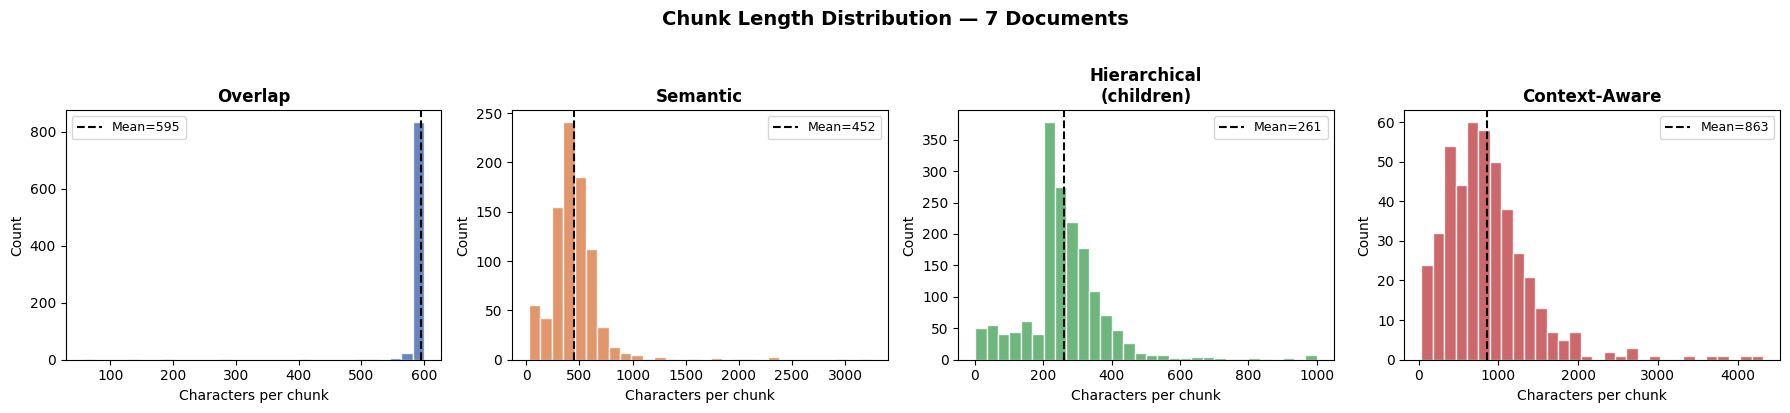

Saved: chunk_distributions.png


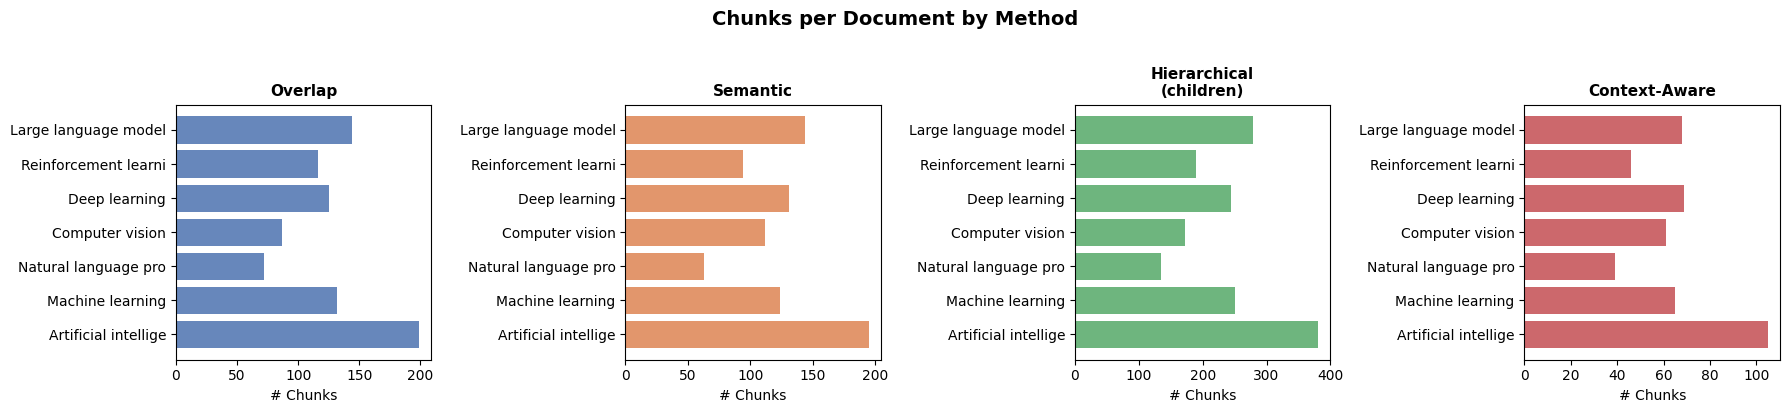

Saved: chunks_per_doc.png


In [17]:
import matplotlib.pyplot as plt

def get_lengths(chunks):
    return [len(c['text'] if isinstance(c, dict) else c) for c in chunks]

methods = {
    "Overlap"              : overlap_chunks,
    "Semantic"             : semantic_chunks,
    "Hierarchical\n(children)" : child_dicts,
    "Context-Aware"        : context_chunks,
}

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']

for ax, (name, chunks), color in zip(axes, methods.items(), colors):
    lengths  = get_lengths(chunks)
    mean_val = sum(lengths) / len(lengths)
    ax.hist(lengths, bins=30, color=color, alpha=0.85, edgecolor='white')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel("Characters per chunk")
    ax.set_ylabel("Count")
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5, label=f'Mean={mean_val:.0f}')
    ax.legend(fontsize=9)

plt.suptitle(f"Chunk Length Distribution — {len(documents)} Documents", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("chunk_distributions.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chunk_distributions.png")

# ── Bonus: chunks per doc per method ─────────────────────────────────────
fig2, axes2 = plt.subplots(1, 4, figsize=(18, 4))
method_items = list(methods.items())

for ax, (name, chunks), color in zip(axes2, method_items, colors):
    doc_ids    = [c['doc_id'] if isinstance(c, dict) else 0 for c in chunks]
    doc_titles = [d['title'][:20] for d in documents]
    counts     = [doc_ids.count(d['doc_id']) for d in documents]
    ax.barh(doc_titles, counts, color=color, alpha=0.85)
    ax.set_title(name, fontsize=11, fontweight='bold')
    ax.set_xlabel("# Chunks")

plt.suptitle("Chunks per Document by Method", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("chunks_per_doc.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chunks_per_doc.png")

---
## 10. Interactive Semantic Search Test

Enter a query and see which chunks each method returns as most relevant.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine

def semantic_top_k_multidoc(query: str, chunks: list, model, k: int = 4) -> list:
    """Top-k retrieval. Works with both string chunks and metadata dicts."""
    texts  = [c['text'] if isinstance(c, dict) else c for c in chunks]
    q_emb  = model.encode([query])
    c_embs = model.encode(texts, batch_size=64, show_progress_bar=False)
    sims   = sk_cosine(q_emb, c_embs)[0]
    top_idx = sims.argsort()[::-1][:k]
    return [(int(i), float(sims[i]), chunks[i]) for i in top_idx]


# ── Change query and TOP_K here ───────────────────────────────────────────
QUERY = "What are the main applications of machine learning?"
TOP_K = 3

print(f"Query: \"{QUERY}\"")
print(f"Corpus: {len(documents)} documents\n")

test_sets = [
    ("Overlap",       overlap_chunks),
    ("Semantic",      semantic_chunks),
    ("Hierarchical",  child_dicts),
    ("Context-Aware", context_chunks),
]

for name, chunks in test_sets:
    print(f"\n{'─'*65}")
    print(f"  [{name}]  Top-{TOP_K} results")
    print(f"{'─'*65}")
    results = semantic_top_k_multidoc(QUERY, chunks, embed_model, k=TOP_K)
    for rank, (idx, score, chunk) in enumerate(results, 1):
        text  = chunk['text'] if isinstance(chunk, dict) else chunk
        doc_t = chunk.get('doc_title', 'N/A')[:40] if isinstance(chunk, dict) else 'N/A'
        print(f"  #{rank} score={score:.3f} | chunk_id={idx} | doc='{doc_t}'")
        print(f"  {text[:280].replace(chr(10),' ')}...\n")

Query: "What are the main applications of machine learning?"
Corpus: 7 documents


─────────────────────────────────────────────────────────────────
  [Overlap]  Top-3 results
─────────────────────────────────────────────────────────────────
  #1 score=0.634 | chunk_id=199 | doc='Machine learning'
  Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine ...

  #2 score=0.621 | chunk_id=434 | doc='Computer vision'
  ask, but methods based on learning are now becoming increasingly common. Examples of applications of computer vision include systems for:  Automatic inspection, e.g., in manufacturing applications; Assisting humans in identification tasks, e.g., a species identification system; C...

  #3 score=0.600 | chunk_id=201 | doc='Machine learning'
  A) through u